# Bagging and Random Forests


[Kevin McGuinness](http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, Dublin City University

---

Here we look at an example where the decision boundary produced by trees can be improved by bagging and random forests.


## Setup

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.datasets import make_circles

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib as mpl


mpl.rcParams['figure.figsize'] = (8,6)
sns.set_style('white')



def scatter_dataset(X, y, palette='Set1'):
    classes = np.unique(y)
    colors = sns.color_palette(palette, len(classes))
    for cls, color in zip(classes, colors):
        values = X[y==cls]
        scatter(values[:, 0], values[:, 1], s=100, c=color, label=cls, edgecolor='k')
    xlabel('$x_1$')
    ylabel('$x_2$')
    legend(frameon=True)


def generate_meshgrid_for_data(X, y):

    # Find span of data
    x0_min, x1_min = np.min(X, axis=0)
    x0_max, x1_max = np.max(X, axis=0)
    x0_range = x0_max - x0_min
    x1_range = x1_max - x1_min

    # Add small buffer around data
    x0_min = x0_min - 0.1 * x0_range
    x0_max = x0_max + 0.1 * x0_range
    x1_min = x1_min - 0.1 * x1_range
    x1_max = x1_max + 0.1 * x1_range

    # Generate linearly spaced points
    x0 = np.linspace(x0_min, x0_max, 100)
    x1 = np.linspace(x1_min, x1_max, 100)

    # Generate meshgrid
    X0, X1 = np.meshgrid(x0, x1)
    return X0, X1


def fill_decision_function(df, X, y, **kwargs):

    # Generate meshgrid
    X0, X1 = generate_meshgrid_for_data(X, y)

    # Evaluate decision function for all points on the grid
    Y = df(np.c_[X0.ravel(), X1.ravel()]).reshape(X0.shape)
    
    save = kwargs.pop('save', False)

    # Plot the decision function
    #figure(figsize=(8,6))
    contourf(X0, X1, Y, **kwargs)
    scatter_dataset(X, y)
    if save:
        savefig(save)


def plot_decision_function(df, X, y, save=None, ):

    # Generate meshgrid
    X0, X1 = generate_meshgrid_for_data(X, y)

    # Evaluate decision function for all points on the grid
    Y = df(np.c_[X0.ravel(), X1.ravel()]).reshape(X0.shape)

    # Plot the decision function
    #figure(figsize=(8,6))
    contour(X0, X1, Y, levels=levels,
            linestyles=['dashed', 'solid', 'dashed'],
            linewidths=1,
            colors='k')

    scatter_dataset(X, y)
    if save:
        savefig(save)
    show()


## Data generation

We use a dataset that is blue over the diagonal and red below. This kind of diagonal line is difficult for a tree to represent, since it can only do axis aligned splits.

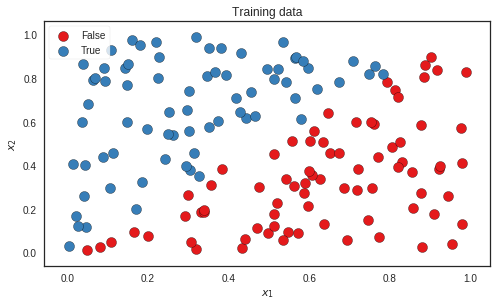

In [ ]:
def make_diagonal_dataset(n=150):
    x1 = np.random.rand(n)
    x2 = np.random.rand(n)
    y = x1 < x2
    return np.c_[x1, x2], y

np.random.seed(10)
X, y = make_diagonal_dataset()
figure(figsize=(8, 4.5))
title('Training data')
scatter_dataset(X, y, palette='Set1')

## Plot the true decision boundary

The true decision boundary is a diagonal line

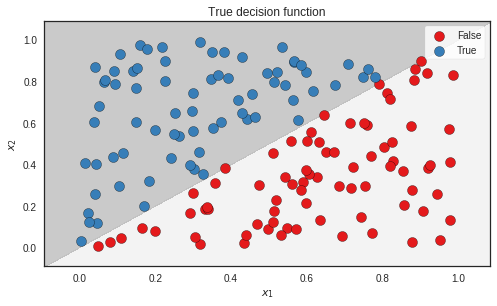

In [ ]:
true_decision_function = lambda X: X[:, 0] < X[:, 1]
figure(figsize=(8,4.5))
title('True decision function')
fill_decision_function(true_decision_function, X, y, alpha=0.3, levels=(0, 0.5, 1))

## Decision tree estimate

The decision function given by a tree is unconvincing.

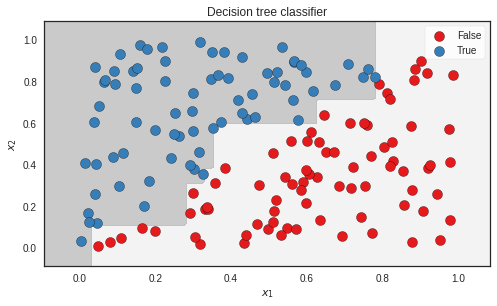

In [ ]:
clf = DecisionTreeClassifier().fit(X, y)
figure(figsize=(8,4.5))
title('Decision tree classifier')
fill_decision_function(clf.predict, X, y, alpha=0.3, levels=(0, 0.5, 1))

The decision tree is also very high variance. Here we generate a different dataset from the same distribution and fit another decision tree. The resulting decision boundary is very different from the first.

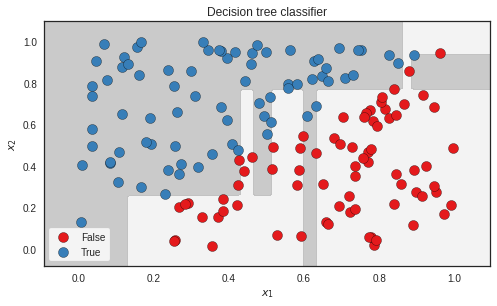

In [ ]:
np.random.seed(20)
X_new, y_new = make_diagonal_dataset()
clf = DecisionTreeClassifier().fit(X_new, y_new)
figure(figsize=(8,4.5))
title('Decision tree classifier')
fill_decision_function(clf.predict, X_new, y_new, alpha=0.3, levels=(0, 0.5, 1))

## Bagging estimate

Bagging can be used to reduce the variance of the trees. The bagged estimator is more convincing.

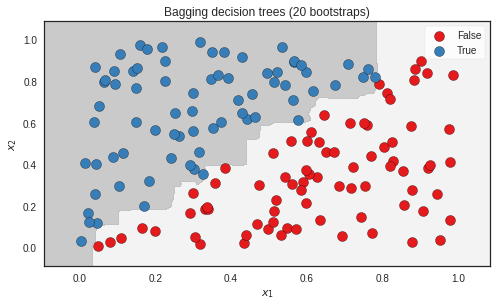

In [ ]:
base_clf = DecisionTreeClassifier()
clf = BaggingClassifier(base_clf, n_estimators=20, random_state=10)
clf.fit(X, y)
df = lambda x: clf.predict_proba(x)[:, 1]
figure(figsize=(8,4.5))
title('Bagging decision trees (20 bootstraps)')
fill_decision_function(df, X, y, alpha=0.3, levels=(0, 0.5, 1))

It is also less sensitive to the particulars of the dataset.

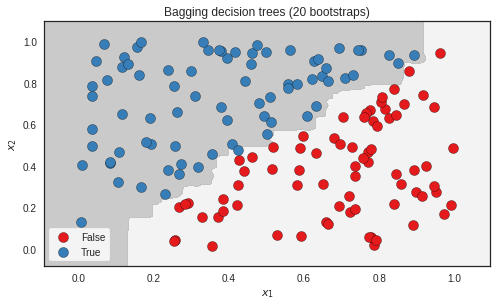

In [ ]:
clf = BaggingClassifier(base_clf, n_estimators=20, random_state=10)
clf.fit(X_new, y_new)
df = lambda x: clf.predict_proba(x)[:, 1]
figure(figsize=(8,4.5))
title('Bagging decision trees (20 bootstraps)')
fill_decision_function(df, X_new, y_new, alpha=0.3, levels=(0, 0.5, 1))

## Random forest estimate

Random forests give very similar results to bagging on this dataset, since we only have 2 features (recall, random forests select a random subset of the features to split on at each node). With more features, however, random forests can reduce variance more than bagging because they are better at producing less correlated predictors.

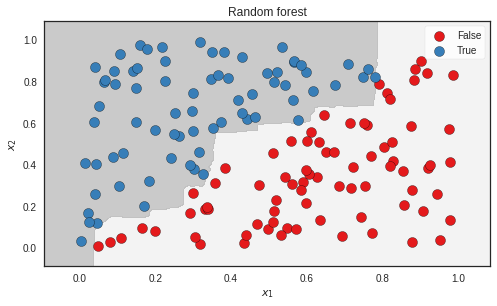

In [ ]:
clf = RandomForestClassifier(n_estimators=20, random_state=11)
clf.fit(X, y)
df = lambda x: clf.predict_proba(x)[:, 1]
figure(figsize=(8,4.5))
title('Random forest')
fill_decision_function(df, X, y, alpha=0.3, levels=(0, 0.5, 1))

## Probability estimates

It's also worth noting that both bagging and random forests allow you to produce probability or confidence estimates by considering the proportion of votes for a particular class. Below we show the confidence/probability estimates from the random forest classifier.

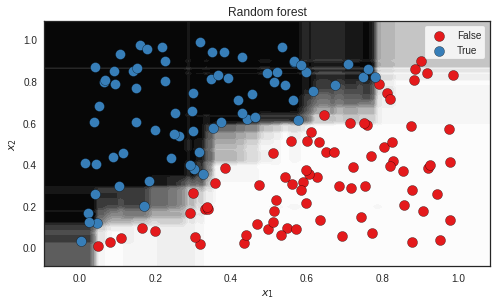

In [ ]:
figure(figsize=(8,4.5))
title('Random forest')
fill_decision_function(df, X, y, alpha=1, levels=linspace(0, 1, 20))